# LSTM Directionality Analysis

This notebook compares Unidirectional vs Bidirectional LSTM performance.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import json
import time
import os
import sys

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from lstm.text_preprocessor import TextPreprocessor
from lstm.lstm_model import LSTMModel, DenseLayer
from lstm.lstm_layer import BidirectionalLSTM


np.random.seed(42)
tf.random.set_seed(42)

os.makedirs('../../models', exist_ok=True)

## Load and Preprocess Data from CSV

In [2]:
# Load data from CSV files
train_df = pd.read_csv('../../../data/train.csv')
valid_df = pd.read_csv('../../../data/valid.csv')
test_df = pd.read_csv('../../../data/test.csv')

# Define label mapping
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Extract texts
train_texts = train_df['text'].values
val_texts = valid_df['text'].values
test_texts = test_df['text'].values

if train_df['label'].dtype == 'object':
    train_labels = train_df['label'].map(label_mapping).values
    val_labels = valid_df['label'].map(label_mapping).values
    test_labels = test_df['label'].map(label_mapping).values
else:
    train_labels = train_df['label'].values
    val_labels = valid_df['label'].values
    test_labels = test_df['label'].values

# Configuration
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

preprocessor = TextPreprocessor(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

print("Fitting the text preprocessor on training data...")
preprocessor.fit(train_texts)

vocab = preprocessor.get_vocabulary()
vocab_size = preprocessor.get_vocab_size()

train_sequences = preprocessor.preprocess(train_texts)
val_sequences = preprocessor.preprocess(val_texts)
test_sequences = preprocessor.preprocess(test_texts)

num_classes = len(np.unique(train_labels))
max_seq_length = MAX_SEQUENCE_LENGTH

print(f"Data loaded and preprocessed successfully!")
print(f"Training data shape: {train_sequences.shape}")
print(f"Label distribution in training data: {np.bincount(train_labels)}")
print(f"Vocabulary size: {vocab_size}")

Fitting the text preprocessor on training data...
Data loaded and preprocessed successfully!
Training data shape: (500, 100)
Label distribution in training data: [192 119 189]
Vocabulary size: 2836


## Model Building Functions

### Model Hyperparameters (Default Values)

- **LSTM Units (`units`)**: Number of LSTM cells in the main recurrent layer. Default values used in experiments: `32`, `64`, and `128`.
- **Embedding Dimension (`embedding_dim`)**: Size of the word embedding vectors. Default: `100`.
- **Direction (`direction`)**: LSTM directionality. Default: `unidirectional`, `Bidirectional`
- **Dropout Rates**: 
    - After LSTM layer: `0.3`
    - After first Dense layer: `0.5`
- **Dense Layer Size**: First dense layer after LSTM uses `32` units with ReLU activation.
- **Output Layer**: Dense layer with `num_classes` units (softmax activation).
- **Optimizer**: Adam with learning rate `0.001`.
- **Loss Function**: Sparse categorical cross-entropy.
- **Batch Size**: `32`
- **Epochs**: `10`

In [3]:
def create_custom_unidirectional_lstm_model(lstm_units=64, embedding_dim=100):
   
    model = LSTMModel(preprocessor=preprocessor)
    
    model.set_label_mapping(label_mapping)
    
    model.add_embedding(vocab_size, embedding_dim, max_seq_length)
    model.add_lstm(lstm_units, return_sequences=False, bidirectional=False)
    model.add_dropout(0.3)
    model.add_dense(32, activation='relu')
    model.add_dropout(0.5)
    model.add_dense(num_classes, activation='softmax')
    
    return model

def create_custom_bidirectional_lstm_model(lstm_units=64, embedding_dim=100):
 
    model = LSTMModel(preprocessor=preprocessor)
    
    model.set_label_mapping(label_mapping)
    
    model.add_embedding(vocab_size, embedding_dim, max_seq_length)
    model.add_lstm(lstm_units, return_sequences=False, bidirectional=True)
    model.add_dropout(0.3)
    model.add_dense(32, activation='relu')
    model.add_dropout(0.5)
    model.add_dense(num_classes, activation='softmax')
    
    return model

def create_unidirectional_lstm_model(lstm_units=64, embedding_dim=100):
   
    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
    
    model.add(LSTM(lstm_units))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def create_bidirectional_lstm_model(lstm_units=64, embedding_dim=100):
   
    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
    
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_and_train_model(model, model_name):
    if not isinstance(model, LSTMModel):
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    if isinstance(model, LSTMModel):
        is_bidirectional = any(isinstance(layer, BidirectionalLSTM) for layer in model.layers)
        lstm_units = 64  
        for layer in model.layers:
            if hasattr(layer, 'units') and not isinstance(layer, BidirectionalLSTM):
                lstm_units = layer.units
                break
        
        if is_bidirectional:
            print("Creating and training bidirectional model")
            
            # Create bidirectional model
            keras_model = create_bidirectional_lstm_model(lstm_units=lstm_units)
            keras_model.build(input_shape=(None, max_seq_length))
            keras_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            print(f"Total parameters: {keras_model.count_params():,}")
            
            # Train the model
            history = keras_model.fit(
                train_sequences, train_labels,
                batch_size=32,
                epochs=10,
                validation_data=(val_sequences, val_labels),
                verbose=1
            )
            
            # Let the load_weights_from_keras method handle all layers
            print("Transferring weights from Keras model to custom model...")
            model.load_weights_from_keras(keras_model)
            print("Weight transfer complete")
            
            # Verify weights are loaded for the model
            for i, layer in enumerate(model.layers):
                if isinstance(layer, BidirectionalLSTM):
                    print(f"Layer {i} bidirectional weights loaded: {layer.weights_loaded}")
                elif isinstance(layer, DenseLayer):
                    print(f"Layer {i} dense weights loaded: {layer.weights is not None}")
        
        else:
            # For unidirectional models
            keras_model = create_unidirectional_lstm_model(lstm_units=lstm_units)
            keras_model.build(input_shape=(None, max_seq_length))
            keras_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            print(f"Total parameters: {keras_model.count_params():,}")
            
            history = keras_model.fit(
                train_sequences, train_labels,
                batch_size=32,
                epochs=10,
                validation_data=(val_sequences, val_labels),
                verbose=1
            )
            
            print("Transferring weights from Keras model to custom model...")
            model.load_weights_from_keras(keras_model)
            print("Weight transfer complete")
    
    else:
        print(f"Total parameters: {model.count_params():,}")
        history = model.fit(
            train_sequences, train_labels,
            batch_size=32,
            epochs=10,
            validation_data=(val_sequences, val_labels),
            verbose=1
        )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return history, training_time

def evaluate_model(model, model_name, history, training_time):
 
    start_time = time.time()
    y_pred = model.predict(test_sequences)
    inference_time = time.time() - start_time
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    f1 = f1_score(test_labels, y_pred_classes, average='macro')
    
    print(f"\n{model_name} Results:")
    print(classification_report(test_labels, y_pred_classes))
    print(f"Macro F1-score: {f1:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")
    
    return f1, history, training_time, inference_time

## Experiment 1: Unidirectional LSTM

In [4]:
model_uni = create_custom_unidirectional_lstm_model()
history_uni, training_time_uni = compile_and_train_model(model_uni, "Unidirectional LSTM")
f1_uni, _, training_time_uni, inference_time_uni = evaluate_model(model_uni, "Unidirectional LSTM", history_uni, training_time_uni)


Training Unidirectional LSTM...
Total parameters: 328,019
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3407 - loss: 1.0909 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3962 - loss: 1.0687 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3817 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0821
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3476 - loss: 1.0853 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4035 - loss: 1.0761 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4003 - loss: 1.0728 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3720 - loss: 1.0782 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3827 - loss: 1.0766 - val_accuracy: 0.3800 - val_loss: 1.

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Experiment 2: Bidirectional LSTM

In [5]:
model_bi = create_custom_bidirectional_lstm_model()
history_bi, training_time_bi = compile_and_train_model(model_bi, "Bidirectional LSTM")
f1_bi, _, training_time_bi, inference_time_bi = evaluate_model(model_bi, "Bidirectional LSTM", history_bi, training_time_bi)


Training Bidirectional LSTM...
Creating and training bidirectional model
Total parameters: 319,827
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3959 - loss: 1.0916 - val_accuracy: 0.5300 - val_loss: 1.0687
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5146 - loss: 1.0361 - val_accuracy: 0.5500 - val_loss: 0.9811
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6118 - loss: 0.8939 - val_accuracy: 0.5900 - val_loss: 0.8681
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6810 - loss: 0.7440 - val_accuracy: 0.6600 - val_loss: 0.7933
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8006 - loss: 0.5522 - val_accuracy: 0.6600 - val_loss: 0.7579
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8509 - loss: 0.4046 - val_accuracy: 0.6900 - val_loss: 0.7887
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8994 - loss: 0.3199 - val_accuracy: 0.7600 - val_loss: 0.7480
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9643 - loss: 0.2217 - val_accuracy: 0.7200 - val_loss: 0.

## Results Comparison

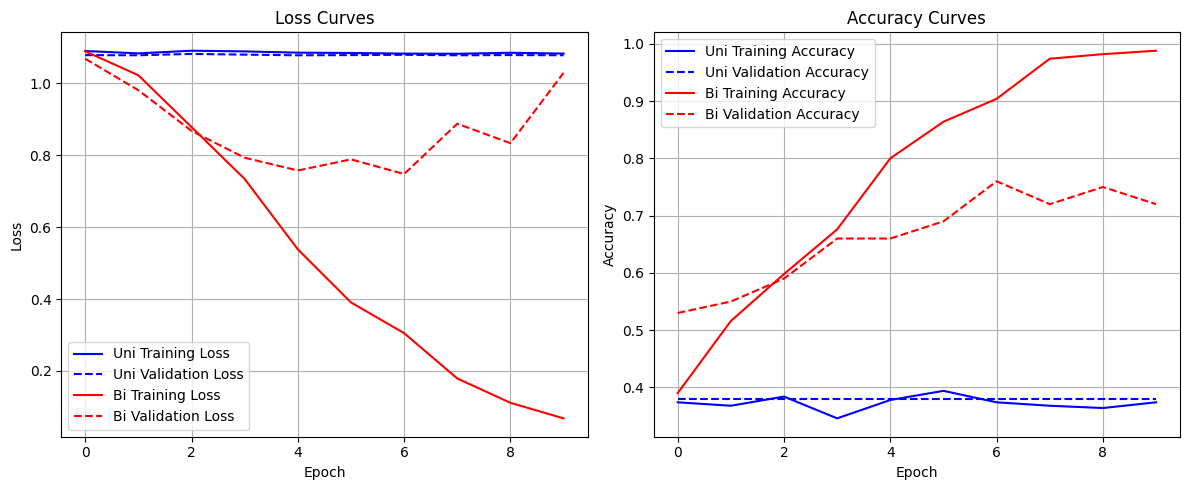

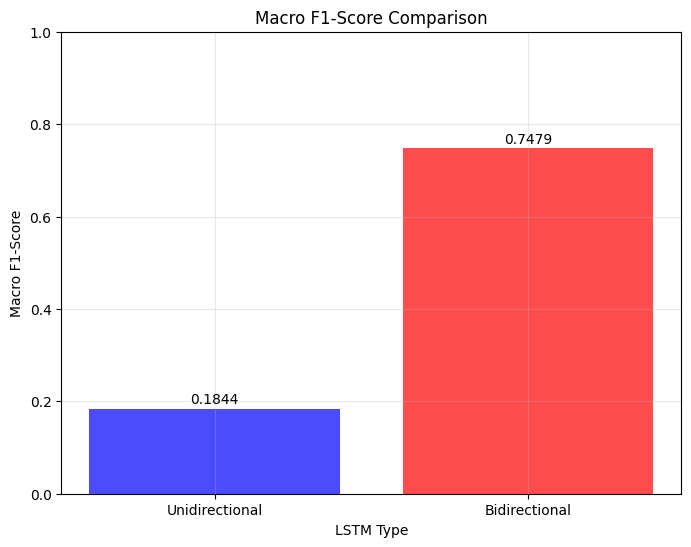

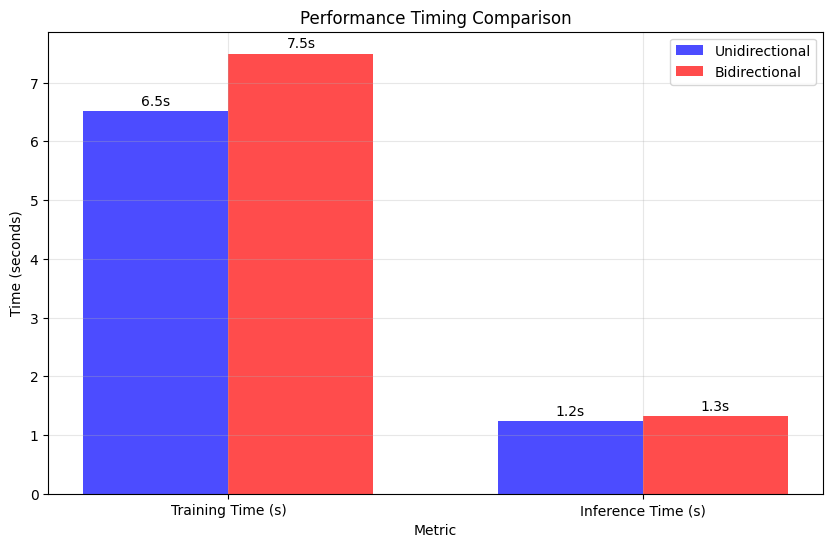

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


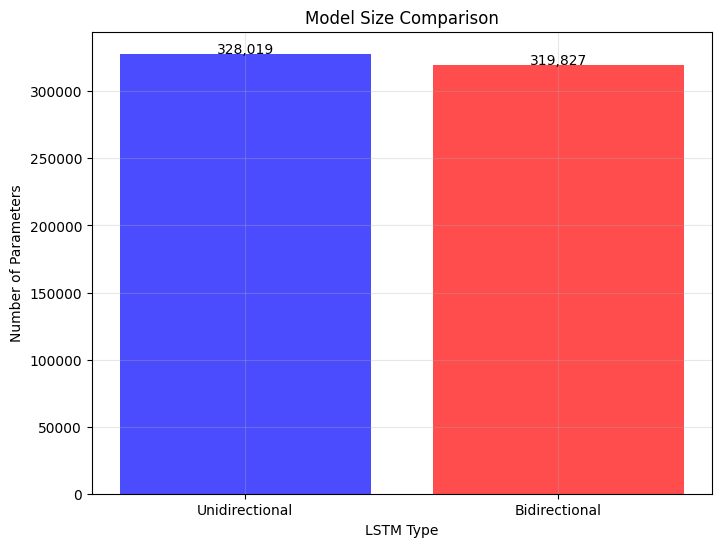


=== LSTM Directionality Analysis Results ===
Unidirectional LSTM: F1-Score = 0.1844, Parameters = 328,019
Bidirectional LSTM: F1-Score = 0.7479, Parameters = 319,827

Performance Difference: 305.47%
Parameter Increase: -2.50%
Training Time Increase: 14.90%
Inference Time Increase: 6.16%


In [6]:
# Plot training/validation loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_uni.history['loss'], label='Uni Training Loss', color='blue')
plt.plot(history_uni.history['val_loss'], label='Uni Validation Loss', color='blue', linestyle='--')
plt.plot(history_bi.history['loss'], label='Bi Training Loss', color='red')
plt.plot(history_bi.history['val_loss'], label='Bi Validation Loss', color='red', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_uni.history['accuracy'], label='Uni Training Accuracy', color='blue')
plt.plot(history_uni.history['val_accuracy'], label='Uni Validation Accuracy', color='blue', linestyle='--')
plt.plot(history_bi.history['accuracy'], label='Bi Training Accuracy', color='red')
plt.plot(history_bi.history['val_accuracy'], label='Bi Validation Accuracy', color='red', linestyle='--')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare F1 scores
f1_scores = [f1_uni, f1_bi]
model_types = ['Unidirectional', 'Bidirectional']

plt.figure(figsize=(8, 6))
plt.bar(model_types, f1_scores, color=['blue', 'red'], alpha=0.7)
plt.title('Macro F1-Score Comparison')
plt.xlabel('LSTM Type')
plt.ylabel('Macro F1-Score')
plt.ylim(0, 1)
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center')
plt.grid(True, alpha=0.3)
plt.show()

metrics = ['Training Time (s)', 'Inference Time (s)']
uni_times = [training_time_uni, inference_time_uni]
bi_times = [training_time_bi, inference_time_bi]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, uni_times, width, label='Unidirectional', color='blue', alpha=0.7)
plt.bar(x + width/2, bi_times, width, label='Bidirectional', color='red', alpha=0.7)
plt.xlabel('Metric')
plt.ylabel('Time (seconds)')
plt.title('Performance Timing Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

for i, v in enumerate(uni_times):
    plt.text(i - width/2, v + 0.1, f'{v:.1f}s', ha='center')
for i, v in enumerate(bi_times):
    plt.text(i + width/2, v + 0.1, f'{v:.1f}s', ha='center')

plt.show()


if isinstance(model_uni, LSTMModel):
    # Get equivalent Keras model
    uni_lstm_units = None
    for layer in model_uni.layers:
        if hasattr(layer, 'units'):
            uni_lstm_units = layer.units
            break
    if uni_lstm_units is None:
        uni_lstm_units = 64
    uni_keras_model = create_unidirectional_lstm_model(lstm_units=uni_lstm_units)
    
    # Build the model before counting parameters
    uni_keras_model.build(input_shape=(None, max_seq_length))
    uni_params = uni_keras_model.count_params()
else:
    uni_params = model_uni.count_params()

if isinstance(model_bi, LSTMModel):
    bi_lstm_units = None
    for layer in model_bi.layers:
        if hasattr(layer, 'units'):
            bi_lstm_units = layer.units
            break
    if bi_lstm_units is None:
        bi_lstm_units = 64
    bi_keras_model = create_bidirectional_lstm_model(lstm_units=bi_lstm_units)
    
    # Build the model before counting parameters
    bi_keras_model.build(input_shape=(None, max_seq_length))
    bi_params = bi_keras_model.count_params()
else:
    bi_params = model_bi.count_params()

plt.figure(figsize=(8, 6))
plt.bar(model_types, [uni_params, bi_params], color=['blue', 'red'], alpha=0.7)
plt.title('Model Size Comparison')
plt.xlabel('LSTM Type')
plt.ylabel('Number of Parameters')
for i, params in enumerate([uni_params, bi_params]):
    plt.text(i, params + 100, f'{params:,}', ha='center')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== LSTM Directionality Analysis Results ===")
print(f"Unidirectional LSTM: F1-Score = {f1_uni:.4f}, Parameters = {uni_params:,}")
print(f"Bidirectional LSTM: F1-Score = {f1_bi:.4f}, Parameters = {bi_params:,}")
print(f"\nPerformance Difference: {((f1_bi - f1_uni) / f1_uni * 100):.2f}%")
print(f"Parameter Increase: {((bi_params - uni_params) / uni_params * 100):.2f}%")
print(f"Training Time Increase: {((training_time_bi - training_time_uni) / training_time_uni * 100):.2f}%")
print(f"Inference Time Increase: {((inference_time_bi - inference_time_uni) / inference_time_uni * 100):.2f}%")

## Save Best Model

In [9]:
if f1_bi > f1_uni:
    best_model = model_bi
    best_type = "Bidirectional"
    best_f1 = f1_bi
else:
    best_model = model_uni
    best_type = "Unidirectional"
    best_f1 = f1_uni

print(f"Best model: {best_type} LSTM with F1-Score: {best_f1:.4f}")

if isinstance(best_model, LSTMModel):
    best_model.save('../../models/best_lstm_directionality_custom', save_preprocessor=True)
    print("Best custom model saved with preprocessor")
    
    if best_type == "Bidirectional":
        keras_model = create_bidirectional_lstm_model()
    else:
        keras_model = create_unidirectional_lstm_model()
        
    keras_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    keras_model.save('../../models/best_lstm_directionality_model.keras')
else:
    best_model.save('../../models/best_lstm_directionality_model.keras')
    
print("Keras model saved as 'best_lstm_directionality_model.keras' for compatibility")

Best model: Bidirectional LSTM with F1-Score: 0.7479
Best custom model saved with preprocessor
Keras model saved as 'best_lstm_directionality_model.keras' for compatibility


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)
